In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [170]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
GetInformation = yahooFinance.Ticker("MSFT")
df = GetInformation.history(period="max")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9628 entries, 1986-03-13 00:00:00-05:00 to 2024-05-24 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9628 non-null   float64
 1   High          9628 non-null   float64
 2   Low           9628 non-null   float64
 3   Close         9628 non-null   float64
 4   Volume        9628 non-null   int64  
 5   Dividends     9628 non-null   float64
 6   Stock Splits  9628 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 601.8 KB


In [171]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054693,0.062736,0.054693,0.060055,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060055,0.063272,0.060055,0.062199,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062199,0.063808,0.062199,0.063272,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063272,0.063808,0.061127,0.061663,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061663,0.062199,0.060055,0.060591,47894400,0.0,0.0


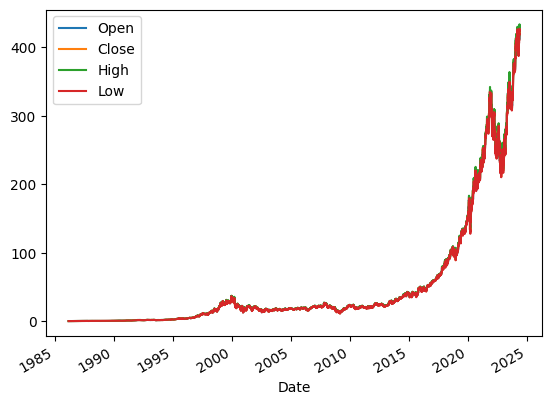

In [172]:
df.plot(y=['Open','Close','High','Low'])
plt.show()

In [173]:
# nsteps time steps and predict npredict value out
def time_series_split(df,nsteps,npredict=1):
  N_timestamps = len(df)
  N_segments = N_timestamps//(nsteps+npredict)
  df_split = np.empty((N_segments,(nsteps+npredict),df.shape[1]),dtype=float)
  scaler = StandardScaler()  # fit transform is important to get rid of the trend
  for i in range(df_split.shape[0]):
    if i != 0:
      df_split[i,:,:] = df.iloc[(-(nsteps+npredict)*(i+1)):(-(nsteps+npredict)*(i))].to_numpy()
    else:
      df_split[i,:,:] = df.iloc[(-(nsteps+npredict)*(i+1)):].to_numpy()
    df_split[i,:,:] = scaler.fit_transform(df_split[i,:,:])
  return df_split

In [182]:
nsteps, npredict = 8*5, 8*1
df1 = time_series_split(df,nsteps,npredict)
test_idx = np.random.randint(0,df1.shape[0]-1,16)
df1_test = df1[test_idx,:,:]
df1_train = df1[[i for i in range(df1.shape[0]) if i not in test_idx],:,:]

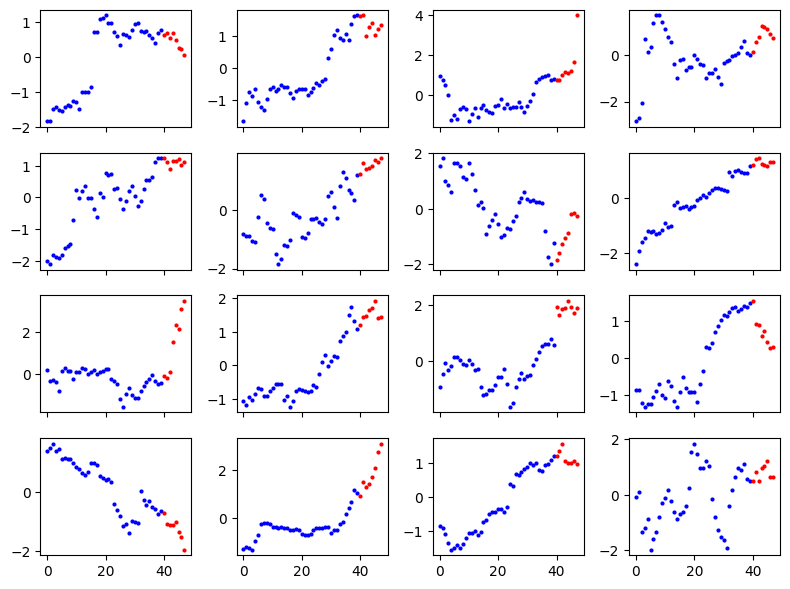

In [183]:
fig, ax = plt.subplots(4,4,figsize=(8,6),sharex=True)
for r in range(4):
  for c in range(4):
    time_slice = r*4+c # np.random.randint(df1.shape[0])
    ax[r,c].plot(range(nsteps),df1_test[time_slice,:-npredict,1],"bo",label=f'{time_slice}',ms=3,markeredgecolor='None')
    ax[r,c].plot(range(nsteps,nsteps+npredict),df1_test[time_slice,-npredict:,1],"ro",ms=3,markeredgecolor='None')
plt.tight_layout()
plt.show()

In [187]:
model = keras.Sequential([
    keras.layers.LSTM(20,input_shape=[None,1]),
    keras.layers.Dense(npredict)
])

In [188]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='MSE')

In [189]:
history = model.fit(df1_train[:,:nsteps,1],df1_train[:,nsteps:,1], epochs = 500,validation_split=0.1);

Epoch 1/500
6/6 [==============================] - 3s 119ms/step - loss: 1.4210 - val_loss: 1.2764
Epoch 2/500
6/6 [==============================] - 0s 20ms/step - loss: 1.3791 - val_loss: 1.2455
Epoch 3/500
6/6 [==============================] - 0s 23ms/step - loss: 1.3405 - val_loss: 1.2175
Epoch 4/500
6/6 [==============================] - 0s 20ms/step - loss: 1.3038 - val_loss: 1.1888
Epoch 5/500
6/6 [==============================] - 0s 20ms/step - loss: 1.2646 - val_loss: 1.1619
Epoch 6/500
6/6 [==============================] - 0s 19ms/step - loss: 1.2315 - val_loss: 1.1365
Epoch 7/500
6/6 [==============================] - 0s 20ms/step - loss: 1.1958 - val_loss: 1.1130
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 1.1579 - val_loss: 1.0899
Epoch 9/500
6/6 [==============================] - 0s 20ms/step - loss: 1.1217 - val_loss: 1.0671
Epoch 10/500
6/6 [==============================] - 0s 20ms/step - loss: 1.0810 - val_loss: 1.0442
Epoch 11/500
6/6 [

1/1 [==============================] - 0s 22ms/step


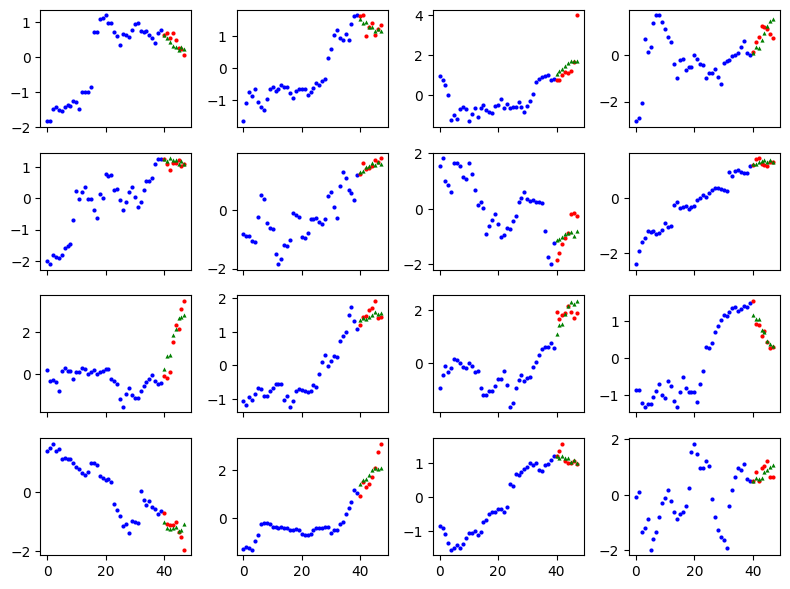

In [190]:
# plot predicted in the test data set
fig, ax = plt.subplots(4,4,figsize=(8,6),sharex=True)
for r in range(4):
  for c in range(4):
    time_slice = 4*r+c #np.random.randint(df1.shape[0])
    val = model.predict(df1_test[time_slice:(time_slice+1),:-npredict,1])
    ax[r,c].plot(range(nsteps),df1_test[time_slice,:-npredict,1],"bo",label=f'{time_slice}',ms=3,markeredgecolor='None')
    ax[r,c].plot(range(nsteps,nsteps+npredict),df1_test[time_slice,-npredict:,1],"ro",ms=3,markeredgecolor='None')
    ax[r,c].plot(range(nsteps,nsteps+npredict),val[0],"g^",ms=3,markeredgecolor='None')
plt.tight_layout()
plt.show()

To do list:


*   So far this is only one feature x(t) and predict x(t+t0)
*   Need to implement a vector feature set, features including various data of a given stock, as well as other stocks.
*   What is the best choice of number of LSTM cells, and does deep LSTM do better?
*   How to calculate confidence interval for forecasting?
*   How to comine LSTM with a classifier on decision to buy, hold or sell?

